# Camera Footprint Calulator
This is a notebook to organzie my thoughts and some code for computing camera (or other field of view based sensors) footprints. 

## Use Cases
The primary needs for this code functionality include deployable python to a Raspberry Pi for image processing, as well as the ability to compute drone camera footprints for high- and low-oblique aerial photography. 

## Source material
At first I computed my own solution using basic trigonometry. This worked for simple nadir footprint, but did not properly account for the perspective transformation of a photo scene given any pitch, roll, or yaw. I quickly realized I would need to generate rays using epipolar geometry concepts. As is usually the case, I started by digging around the interwebs for previous solutions. I ended up discovering a [Stack Overflow](https://stackoverflow.com/questions/38099915/calculating-coordinates-of-an-oblique-aerial-image) discussion (isn't that always the way), where a java-based solution was suggested based on the thesis of Github user [Milan Zelenka](https://github.com/zelenmi6). Another enterprising Github user, [Luigi Pirelli](https://gist.github.com/luipir) has kindly [ported](https://gist.github.com/luipir/dc33864b53cf6634f9cdd2bce712d3d9) the original java into python, and so here we are. I love the internet! 

I have taken this excellent script and made a few minor tweaks to fit this purpose, mostly for convenience. For now, this Notebook is just to help me think my use case through. A standalone script/class is the likely output.

Thanks for reading,

Frank Engel


In [1]:
# Modules
import math
from mpl_toolkits import mplot3d
#%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from camera_calculator import CameraCalculator

#INPUTS
cam_name = "ACTI A31"
units= "feet"
horz_fov_deg = 106.9
vert_fov_deg = 79.9
inst_height = 4
pitch_deg = 10.
roll_deg = 10.
yaw_deg = 90.
camera_pos = (10., 5., inst_height)

# Initialize the class
c = CameraCalculator()


In [2]:
def centroid(arr):
    """Compute the centroid coordinate of an numpy array of XYZ points"""
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return sum_x/length, sum_y/length, sum_z/length

def getFootprint(FOVh,FOVv,roll,pitch,yaw,camera_pos):
    """Convenience function to drive inputs for CameraCalculator class"""
    bbox=c.getBoundingPolygon(FOVh,FOVv,roll,pitch,yaw,camera_pos)
    Xp = np.array([bbox[0].x, bbox[1].x, bbox[2].x, bbox[3].x,bbox[0].x])
    Yp = np.array([bbox[0].y, bbox[1].y, bbox[2].y, bbox[3].y,bbox[0].y])
    Zp = np.array([bbox[0].z, bbox[1].z, bbox[2].z, bbox[3].z,bbox[0].z])
    footprint = np.vstack((Xp,Yp,Zp)).T
    principle_point = centroid(footprint[0:4,:]) # Don't average the extra point
    return footprint, principle_point


## Plots

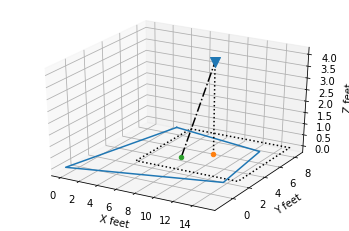

In [3]:
ax = plt.axes(projection='3d')
ax.scatter(camera_pos[0],camera_pos[1],camera_pos[2], marker="v", s=100)

# Plot Nadir footprint
fp1, PP1 = getFootprint(horz_fov_deg, vert_fov_deg, 0, 0, 90, camera_pos)
ax.plot(fp1[:,0], fp1[:,1], fp1[:,2], linewidth=1.5, linestyle=":", color='black')
ax.scatter(PP1[0], PP1[1], PP1[2])

# Plot perspective footprint
fp2, PP2 = getFootprint(horz_fov_deg, vert_fov_deg, roll_deg, pitch_deg, yaw_deg, camera_pos)
ax.plot(fp2[:,0], fp2[:,1], fp2[:,2])
ax.scatter(PP2[0], PP2[1], PP2[2])

# Plot ray from camera to footprint Principle Points
ax.plot3D((PP1[0],camera_pos[0]),(PP1[1],camera_pos[1]),(PP1[2],camera_pos[2]), 'black', linestyle=":")
ax.plot3D((PP2[0],camera_pos[0]),(PP2[1],camera_pos[1]),(PP2[2],camera_pos[2]), 'black', linestyle="-.")


ax.set_xlabel('X '+ units)
ax.set_ylabel('Y '+ units)
ax.set_zlabel('Z '+ units)
ax.set_aspect('equal', 'datalim')
plt.show()
